# Accessing raw data

Most users of the synaptic physiology dataset should find that our sqlite database files contain all of the processed and analyzed data they need. In a few cases, however, it may be desirable to load raw data from our original NWB files. These files contain multichannel recordings that describe all electrical stimuli applied during an experiment.

To start, pick an experiment from our database:

In [ ]:
from aisynphys.database import SynphysDatabase

# load the latest version of the small database
db = SynphysDatabase.load_current('small')

# arbitrarily pick a single experiment
expt = db.list_experiments()[1996]

### Downloading NWB files

The NWB fie for this experiment can be accessed by the `nwb_file` attribute of the experiment obj:

In [34]:
expt.nwb_file

  /home/luke/ai_synphys_cache/raw_data_files/1537820585.767/data.nwb
  [####################]  100.00% (1.56 GB / 1.6 GB)  6.444 MB/s  0:00:00 remaining
  done.


'/home/luke/ai_synphys_cache/raw_data_files/1537820585.767/data.nwb'

This causes the NWB file to be downloaded (if it hasn't already) and stored in a cache location on your local drive. The file can now be opened from this location by any HDF5 tools. However, we strongly recommend using the tools provided by aisynphys to read these files, since they will handle correctly parsing the file structure and metadata within:

In [35]:
# download NWB file (if needed) and load the data
data = expt.data

data

<MultiPatchDataset /home/luke/ai_synphys_cache/raw_data_files/1537820585.767/data.nwb>

### Loading traces and metadata fom NWB

The `data` object contains attributes and methods needed to access sweeps, test pulses, and metadata.
(Note: use `help(data)` to get information on the methods and attributes available from here).

In [14]:
# how many sweeps in this dataset?
len(data.contents)

79

Before we dive into the raw data here, let's go back to the database and see where we expect to find synapses in this dataset:

In [42]:
print("Electrode IDs with synapses:")
print("pre -> post")
for pair in expt.pair_list:
    if pair.has_synapse:
        print(f" {pair.pre_cell.electrode.device_id}      {pair.post_cell.electrode.device_id}")

Electrode IDs with synapses:
pre -> post
 0      1
 6      0
 6      7


This indicates that we can expect to find synaptic events recorded on electrodes 0, 1, and 7 in this dataset.

Now let's pick an arbitrary sweep to inspect:

In [43]:
# select an arbitrary sweep
sweep = data.contents[10]

# which devices (electrodes 0-7) participated in this sweep?
sweep.devices

[0, 1, 4, 5, 6, 7]

In [44]:
# print some data about the stimulus and recordings on each electrode:
for dev_id in sweep.devices:
    recording = sweep[dev_id]
    print(recording)

<MultiPatchProbe device:0 mode=VC holding=-55 10.0 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:1 mode=VC holding=-55 10.1 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:4 mode=VC holding=-55 10.4 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:5 mode=VC holding=-55 10.5 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:6 mode=VC holding=-55 10.6 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:7 mode=VC holding=-55 10.7 stim=PulseTrain_20Hz_DA_0>


These recordings were done in voltage clamp mode, holding at -55 mV, and with 20 Hz pulse train stimuli.

Each recording contains two channels of data:

In [47]:
recording.channels

['primary', 'command']

Let's plot the raw data:

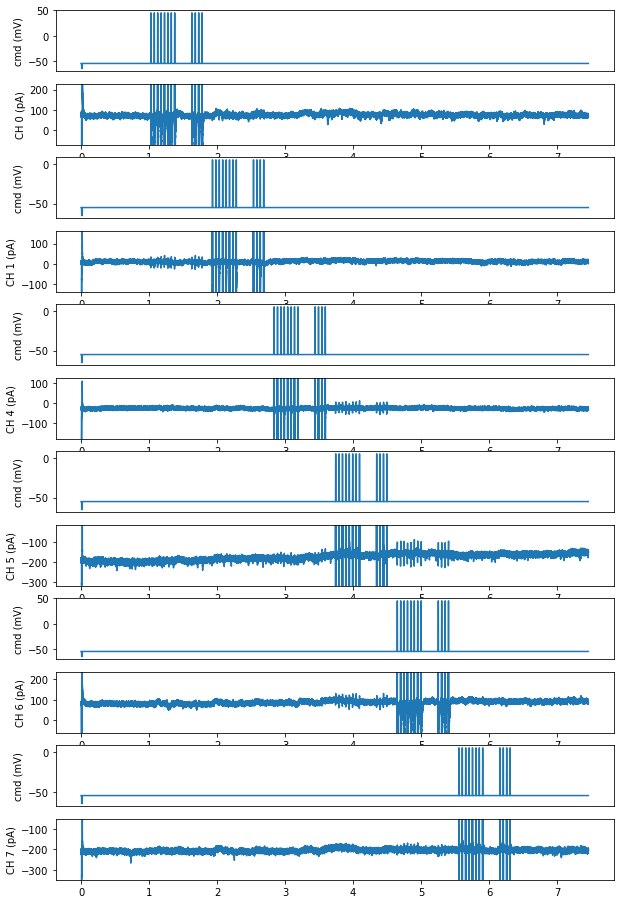

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(sweep.devices) * 2, 1, figsize=(10, 16))

for i, dev_id in enumerate(sweep.devices):
    recording = sweep[dev_id]
    command = recording['command']
    ax[i*2].plot(command.time_values, command.data * 1e3)
    ax[i*2].set_ylabel('cmd (mV)')
    ax[i*2].axes.xaxis.set_visible(False)

    primary = recording['primary']
    ax[i*2+1].plot(primary.time_values, primary.data * 1e12)
    ax[i*2+1].set_ylabel(f'CH {dev_id} (pA)')

    baseline = primary.data.mean() * 1e12
    ax[i*2+1].set_ylim(baseline-150, baseline+150)
    

The recording objects also contain metadata about their stimuli:

In [61]:
recording.stimulus

<MiesStimulus "PulseTrain_20Hz_DA_0" 0x7f37985967f0>

In [62]:
recording.stimulus.items

(<Offset "holding potential" 0x7f378f9a58e0>,
 <SquarePulse "test pulse" 0x7f378f755790>,
 <SquarePulse "Epoch 0" 0x7f3799128f10>,
 <SquarePulseTrain "Epoch 1" 0x7f37904d6b80>,
 <SquarePulse "Epoch 2" 0x7f37904d6a60>,
 <SquarePulseTrain "Epoch 3" 0x7f37904d67f0>,
 <SquarePulse "Epoch 4" 0x7f378ff61310>)

In [70]:
recording.stimulus.items[3].interval

0.05

## Where to get more information

Most of the objects we have loaded here are self-documented, so calling `help()` on the object should provide useful information: 

In [73]:
help(data)

Help on MultiPatchDataset in module aisynphys.data.data object:

class MultiPatchDataset(neuroanalysis.miesnwb.MiesNwb)
 |  MultiPatchDataset(filename)
 |  
 |  Extension of neuroanalysis data abstraction layer to include
 |  multipatch-specific metadata.
 |  
 |  Method resolution order:
 |      MultiPatchDataset
 |      neuroanalysis.miesnwb.MiesNwb
 |      neuroanalysis.data.dataset.Dataset
 |      neuroanalysis.data.dataset.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  create_sync_recording(self, sweep_id)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from neuroanalysis.miesnwb.MiesNwb:
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, filename)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  close(self)
 |  
 |  notebook(self)
 |      Return compiled data from

In [46]:
help(recording)

Help on MultiPatchProbe in module aisynphys.data.data object:

class MultiPatchProbe(MultiPatchRecording)
 |  MultiPatchProbe(recording)
 |  
 |  A 12-pulse stimulus/response used to probe for synaptic connections.
 |  
 |  Method resolution order:
 |      MultiPatchProbe
 |      MultiPatchRecording
 |      neuroanalysis.miesnwb.MiesRecording
 |      neuroanalysis.data.dataset.PatchClampRecording
 |      neuroanalysis.data.dataset.Recording
 |      neuroanalysis.data.dataset.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  stim_params(self)
 |      Return induction frequency and recovery delay.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from MultiPatchRecording:
 |  
 |  __getattr__(self, attr)
 |  
 |  __init__(self, recording)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  ----------------------------------------------------------------------
 | 

In [72]:
help(recording['primary'])

Help on MiesTSeries in module neuroanalysis.miesnwb object:

class MiesTSeries(neuroanalysis.data.dataset.TSeries)
 |  MiesTSeries(recording, chan)
 |  
 |  Method resolution order:
 |      MiesTSeries
 |      neuroanalysis.data.dataset.TSeries
 |      neuroanalysis.data.dataset.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, recording, chan)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  data
 |      The array of sample values.
 |  
 |  shape
 |      The shape of the array stored in this TSeries.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from neuroanalysis.data.dataset.TSeries:
 |  
 |  __add__(self, x)
 |  
 |  __getitem__(self, item)
 |  
 |  __len__(self)
 |  
 |  __mul__(self, x)
 |  
 |  __repr__(self)
 |      Return repr(self).
 | 

In [74]:
help(recording.stimulus.items[3])

Help on SquarePulseTrain in module neuroanalysis.stimuli object:

class SquarePulseTrain(Stimulus)
 |  SquarePulseTrain(start_time, n_pulses, pulse_duration, amplitude, interval, description='square pulse train', units=None, parent=None)
 |  
 |  A train of identical, regularly-spaced square pulses.
 |  
 |  Parameters
 |  ----------
 |  start_time : float
 |      The starting time of the first pulse in the train, relative to the start time of the parent
 |      stimulus.
 |  n_pulses : int
 |      The number of pulses in the train.
 |  pulse_duration : float
 |      The duration in seconds of a single pulse.
 |  amplitude : float
 |      The amplitude of a single pulse.
 |  interval : float
 |      The time in seconds between the onset of adjacent pulses.
 |  description : str
 |      Optional string describing the stimulus.
 |  units : str | None
 |      Optional string describing the units of values in the stimulus.
 |  
 |  Method resolution order:
 |      SquarePulseTrain
 |      